In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading ground truth landmarks
Reading ground truth odometry
Creating animation
Saving animation
Animation saved
RMSE: 3.673282000549 maxE: 8.689982254885914 number of particals: 1000
Creating animation
Saving animation
Animation saved
RMSE: 0.2104676578073433 maxE: 1.1104634283148096 number of particals: 500
Creating animation
Saving animation
Animation saved
RMSE: 6.696593138459682 maxE: 12.308955291731163 number of particals: 100
Creating animation
Saving animation
Animation saved
RMSE: 9.56656620139032 maxE: 16.050122900918787 number of particals: 50
Creating animation
Saving animation
Animation saved
RMSE: 3.414946971289088 maxE: 8.20126836471311 number of particals: 30
Creating animation
Saving animation
Animation saved
RMSE: 8.877273101081144 maxE: 15.885249392164376 number of particals: 20
Creating animation
Saving animation
Animation saved
RMSE: 4.504491535086457 maxE: 9.309362615125309 number of particals: 10
Creating animation
Saving animation
Animation saved
RMSE: 3.2717602

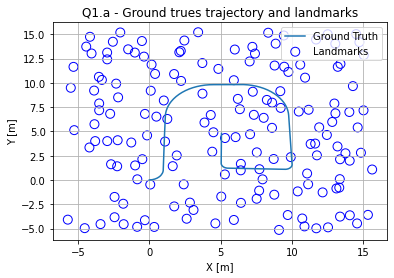

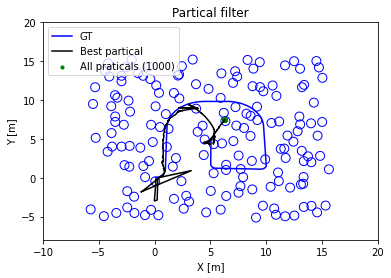

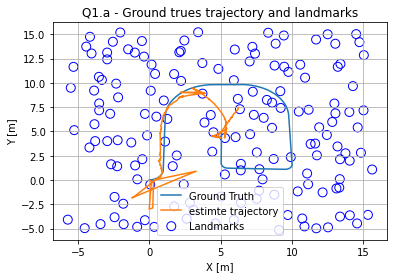

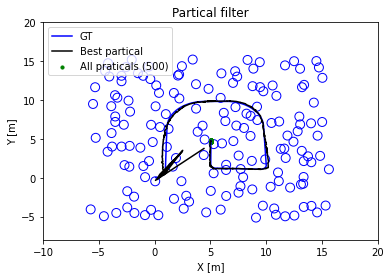

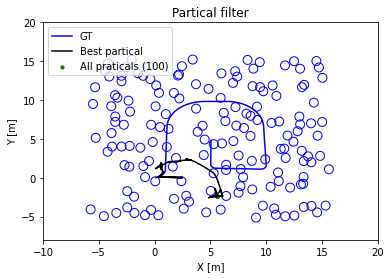

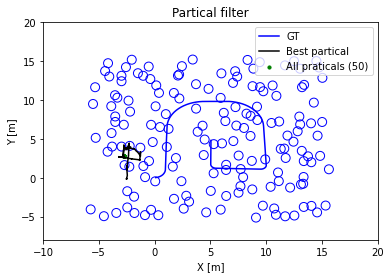

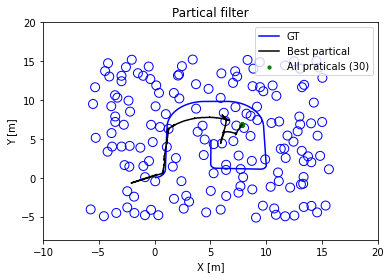

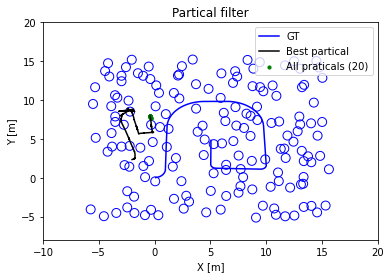

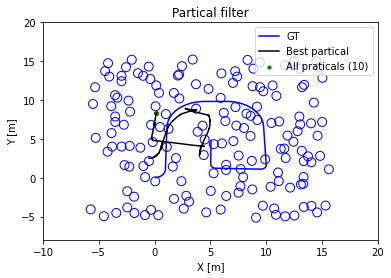

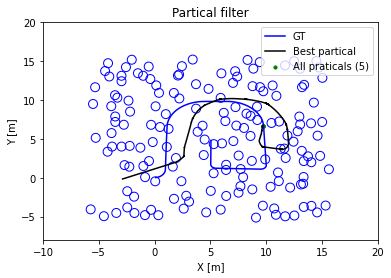

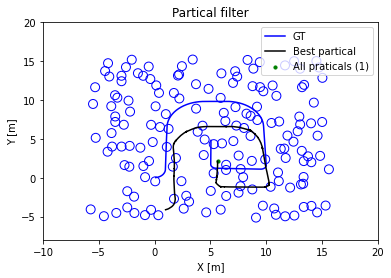

In [2]:
! cp /content/drive/MyDrive/mapping_and_perception/project_3/Q_1_Partical_Filter/ParticlesFilter.py .
! cp /content/drive/MyDrive/mapping_and_perception/project_3/Q_1_Partical_Filter/read_ex1_data.py .
! cp /content/drive/MyDrive/mapping_and_perception/project_3/Q_1_Partical_Filter/graphs.py .
import copy
import read_ex1_data
from ParticlesFilter import *
import numpy as np
import matplotlib.pyplot as plt
import math
from graphs import *
np.random.seed(333)


def main():
    """
    This function in my implementation for Particles filter
    """

    """ Load data """
    print("Reading ground truth landmarks")
    trueLandmarks = np.array(read_ex1_data.read_landmarks("/content/drive/MyDrive/mapping_and_perception/project_3/Q_1_Partical_Filter/Landmarks/LastID_1.csv"))

    print("Reading ground truth odometry")
    trueOdometry = read_ex1_data.read_odometry("/content/drive/MyDrive/mapping_and_perception/project_3/Q_1_Partical_Filter/odometry.dat")

    """ Calculate true trajectory """
    trueTrajectory = np.zeros((trueOdometry.__len__(), 3))
    for i in range(1, trueOdometry.__len__()):
        dr1 = trueOdometry[i - 1]['r1']
        dt = trueOdometry[i-1]['t']
        dr2 = trueOdometry[i - 1]['r2']
        theta = trueTrajectory[i - 1, 2]
        dMotion = np.expand_dims(np.array([dt * math.cos(theta + dr1), dt * math.sin(theta + dr1), dr1 + dr2]), 0)
        trueTrajectory[i, :] = trueTrajectory[i-1, :] + dMotion

    """ Plot Q1 """
    plt.figure('Q1 - Ground trues trajectory and landmarks')
    plt.plot(trueTrajectory[:, 0], trueTrajectory[:, 1])
    plt.scatter(trueLandmarks[:, 0], trueLandmarks[:, 1], s=80, facecolors='none', edgecolors='b')
    plt.grid()
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.legend(['Ground Truth', 'Landmarks'])
    plt.title('Q1.a - Ground trues trajectory and landmarks')

    """ Generate measurement odometry """
    sigma_r1 = 0.01 #TODO#  # [rad / sec]
    sigma_t = 0.1 #TODO#  # [m / sec]
    sigma_r2 = 0.01  #TODO#  # [rad / sec]
    measurmentOdometry = dict()
    for timestamp in range(trueOdometry.__len__()):
        measurmentOdometry[timestamp] = {'r1': trueOdometry[timestamp]['r1'],
                                         't': trueOdometry[timestamp]['t'],
                                         'r2': trueOdometry[timestamp]['r2']}

    """ Create CParticlesFilter object """
     #TODO#
    list_numberOfPaticles = [1000,500,100,50,30,20,10,5,1]
    #numberOfPaticles = 1000
    for numberOfPaticles in list_numberOfPaticles:
      #lidar measserment noise
      sigma_r = 1
      sigma_phi = 0.1
      worldLandmarks = trueLandmarks
      estimatedTrajectory = np.empty((1,6))

      best_positions_list = []
      frame_list = []
      pf = ParticlesFilter(numberOfPaticles,worldLandmarks,sigma_r1, sigma_t, sigma_r2)
      for timestamp in range(1,trueOdometry.__len__()):
        Ut = measurmentOdometry[timestamp-1]
        ditance_x_y = copy.copy(np.subtract(worldLandmarks , trueTrajectory[timestamp, 0:2]))
        closeset_landmark_idx  = np.argmin(np.sqrt(np.power(ditance_x_y[:,0],2) + np.power(ditance_x_y[:,1],2)))
        closeset_landmark = worldLandmarks[closeset_landmark_idx]
        r_measserment = np.sqrt(np.power(closeset_landmark[0] - trueTrajectory[timestamp, 0],2) + np.power(closeset_landmark[1] - trueTrajectory[timestamp, 1],2)) + np.random.normal(0,sigma_r) #np.random.normal(0,np.power(sigma_r,2))
        phi_measserment = np.arctan2(closeset_landmark[1] - trueTrajectory[timestamp, 1],closeset_landmark[0] - trueTrajectory[timestamp, 0]) + np.random.normal(0,sigma_phi) # + np.random.normal(0,np.power(sigma_phi,2))
        Zt = [r_measserment,phi_measserment]

        current_particales = copy.copy(pf.apply(Zt, Ut))
        #print("current_particales" , current_particales)
        best_positions = pf.bestKParticles(1)
        frame_list.append([trueTrajectory[timestamp, 0:2],best_positions,current_particales])
        estimatedTrajectory = np.vstack((estimatedTrajectory,best_positions))

      ani = build_animation(frame_list,trueLandmarks, 'Partical filter', "X [m]", "Y [m]", 'GT', 'Best partical', 'All praticals ({})'.format(numberOfPaticles))
      save_animation(ani, "/content/drive/MyDrive/mapping_and_perception/project_3/Q_1_Partical_Filter", 'Partical filter animation (number of particles: {})'.format(numberOfPaticles))

      RMSE, maxE = calc_RMSE_maxE(trueTrajectory[:,:2], estimatedTrajectory[:,:2])
      print("RMSE:",RMSE ,"maxE:" ,maxE, "number of particals:" ,numberOfPaticles)

      if (numberOfPaticles == 1000):
        plt.figure('Q1 - Ground trues trajectory , estimte trajectory and landmarks 1000 particals')
        plt.plot(trueTrajectory[:, 0], trueTrajectory[:, 1])
        plt.plot(estimatedTrajectory[:, 0], estimatedTrajectory[:, 1])
        plt.scatter(trueLandmarks[:, 0], trueLandmarks[:, 1], s=80, facecolors='none', edgecolors='b')
        plt.grid()
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")
        plt.legend(['Ground Truth','estimte trajectory', 'Landmarks'])
        plt.title('Q1.a - Ground trues trajectory and landmarks')

    
if __name__ == "__main__":
    main()